# Set-up

In [1]:
import wrds
import pandas as pd
import numpy as np
import os

# Get the current working directory
script_dir = os.getcwd()

# Set the working directory to the current script's directory (which in this case is already the working directory)
os.chdir(script_dir)

print(f"Working directory is set to: {script_dir}")

# Connect to WRDS
db = wrds.Connection(wrds_username='zrsong')

# Define the start and end dates
start_date = '2010-01-01'
end_date = '2024-06-30'

'''
# Use S&P ratings data as Compustat ratings data were discontinued in 2017
# Query the S&P ratings data
query = f"""
    SELECT gvkey, ratingdate, ratingsymbol
    FROM ciq_ratings.wrds_erating 
    WHERE ratingdate >= '{start_date}' AND ratingdate <= '{end_date}'
"""

# Execute the query and fetch the data
ratings_date = db.raw_sql(query)

# Save the data to a CSV file
ratings_date.to_csv('../Data/ratings_data.csv', index=False)
'''

Working directory is set to: /Users/zrsong/Dropbox (MIT)/Research Projects/Tax and M&A Debt/Code
Loading library list...
Done


'\n# Use S&P ratings data as Compustat ratings data were discontinued in 2017\n# Query the S&P ratings data\nquery = f"""\n    SELECT gvkey, ratingdate, ratingsymbol\n    FROM ciq_ratings.wrds_erating \n    WHERE ratingdate >= \'{start_date}\' AND ratingdate <= \'{end_date}\'\n"""\n\n# Execute the query and fetch the data\nratings_date = db.raw_sql(query)\n\n# Save the data to a CSV file\nratings_date.to_csv(\'../Data/ratings_data.csv\', index=False)\n'

# Compustat

In [2]:
fund_table = 'funda'

varlist = ['conm', 'tic', 'cusip','fyear', 'fyr', 'at','capx', 'ceq', 'cogs', 'csho', 'dlc', 'dlcch','dltt', 'dp', 'ib', 'itcb', 
           'lt', 'mib', 'naicsh', 'ni', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'revt', 'sale', 'ebitda', 'dpc', 'oiadp', 'oibdp',
           'seq', 'sich', 'txdb', 'txdi', 'txditc', 'wcapch', 'xint', 'xlr', 'xrd', 'xsga', 'ppegt', 'xrd', 'ebit']

query = """SELECT gvkey, datadate, {}
           FROM comp.{}
           WHERE datafmt = 'STD'
           AND popsrc = 'D'
           AND indfmt = 'INDL'
           AND consol = 'C'
           AND fyear>=1990;""".format(", ".join(varlist), fund_table)

compa = db.raw_sql(query, date_cols=['datadate'])

del(fund_table, varlist, query)

In [3]:
# Import SIC codes from comp.company
sic_table = 'company'
query = "SELECT gvkey, sic FROM comp.company"
sic_codes = db.raw_sql(query)

# Merge SIC codes back to compa dataframe
compa = compa.merge(sic_codes, how='left', on='gvkey')

In [4]:
# all colnames of compa
# check if sic exists
# for each gvkey fyear, keep the one with the highest at
compa = compa.sort_values(['gvkey', 'fyear', 'at'], ascending=[True, True, False])
compa = compa.drop_duplicates(subset=['gvkey', 'fyear'], keep='first')

In [5]:
# missing values of ebitda (due to missing dp/oiabp)
compa['ebitda'] = compa['ebitda'].fillna(compa['ebit'] + compa['dp'])
# replace ebitda = ebit if ebitda is missing
compa['ebitda'] = compa['ebitda'].fillna(compa['ebit'])
# replace ebida = ni if ebitda is still missing
compa['ebitda'] = compa['ebitda'].fillna(compa['ni'])

In [6]:
# If there are missing values between years for ebitda, fill with average of prev and post years
compa['ebitda'] = compa['ebitda'].fillna((compa['ebitda'].shift(1) + compa['ebitda'].shift(-1)) / 2)
# fill with prev/post if there are consecutive missing values
compa['ebitda'] = compa['ebitda'].fillna(method='ffill').fillna(method='bfill')

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_63900/281724331.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  compa['ebitda'] = compa['ebitda'].fillna(method='ffill').fillna(method='bfill')


In [7]:
# output csv. format
compa.to_csv("../Data/Raw/compustat_annual.csv", index=False)

In [8]:

# Quarterly Compustat data
fund_table = 'fundq'
varlist = ['gvkey', 'conm', 'tic', 'cusip','fyearq', 'fqtr', 'fyr', 'atq','capxy', 'ceqq', 'cogsq', 
           'cshoq', 'dlcq', 'dlcchy','dlttq', 'dpq', 'ibq', 'itccy', 'fic', 'pstkrq',
           'ltq', 'mibq', 'niq', 'prstkccy', 'pstkq', 'req', 'revtq', 'saleq',
           'seqq', 'txdbq', 'txdiq', 'txditcq', 'wcapchy', 'xinty', 'xrdq', 'xrdy', 'xsgaq',
           'mkvaltq', 'epspxq', 'epsfxq', 'ajexq', 'prccq', 'oancfy', 'ivncfy', 'rdq', 'ppegtq', 'ppentq']
# Join the list into a comma-separated string
varlist_str = ", ".join(varlist)
# use the varlist above to query quarterly compustat data (don't use join(varlist) as it will return a string)
query = f"""
    SELECT {varlist_str}
    FROM comp_na_daily_all.{fund_table}
    WHERE datadate >= '{start_date}' AND datadate <= '{end_date}'
"""
compq = db.raw_sql(query)

In [9]:
# How to deal with duplicates? Keep last available entry (datadate)
compq.dropna(subset=['fyearq', 'fqtr'], inplace=True)
compq.sort_values(['gvkey','fyearq', 'fqtr', 'atq'], inplace=True)
compq = compq[~compq.duplicated(['gvkey', 'fyearq', 'fqtr'], keep='last')]

In [10]:
duplicate_columns = compq.columns[compq.columns.duplicated()]
print("Duplicate columns:", duplicate_columns)

Duplicate columns: Index([], dtype='object')


In [11]:
# Calculating BE
# Shareholder Equity
compq['se'] = compq['seqq']
# Uses Common Equity (ceq) + Preferred Stock (pstk) if SEQ is missing:
compq['se'].fillna((compq['ceqq'] + compq['pstkq']), inplace=True)
# Uses Total Assets (at) - Liabilities (lt) + Minority Interest (mib, if available), if others are missing
compq['se'].fillna((compq['atq'] - compq['ltq'] + compq['mibq'].fillna(0)), inplace=True)

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_63900/4278593784.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  compq['se'].fillna((compq['ceqq'] + compq['pstkq']), inplace=True)
/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_63900/4278593784.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

In [12]:
# Preferred Stock
# Preferred Stock (Redemption Value)
compq['ps'] = compq['pstkrq']
# Uses Preferred Stock (Liquidating Value (pstkl)) if Preferred Stock (Redemption Value) is missing (pstkl doesnt' exist for quarterly data)
# compq['ps'].fillna(compq['pstkl'], inplace=True)
# Uses Preferred Stock (Carrying Value (pstk)) if others are missing
compq['ps'].fillna(compq['pstkq'], inplace=True)

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_63900/4121065189.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  compq['ps'].fillna(compq['pstkq'], inplace=True)


In [13]:
# Deferred Taxes
# Uses Deferred Taxes and Investment Tax Credit (txditc)
compq['dt'] = compq['txditcq']
# This was Novy-Marx old legacy code. We drop this part to be in accordance with Ken French.
# Uses Deferred Taxes and Investment Tax Credit(txdb) + Investment Tax Credit (Balance Sheet) (itcb) if txditc is missing (itcb (Investment Tax Credit (Balance Sheet)) doesn't exist for quarterly data)
compq['dt'].fillna(compq['txdbq'].fillna(0), inplace=True)
# If all measures are missing, set to missing
compq.loc[pd.isnull(compq['txditcq']) & pd.isnull(compq['txdbq']), 'dt'] = np.nan

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_63900/1696288597.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  compq['dt'].fillna(compq['txdbq'].fillna(0), inplace=True)


In [14]:
# Book Equity
# Book Equity (BE) = Share Equity (se) - Prefered Stocks (ps) + Deferred Taxes (dt)
compq['be'] = (compq['se']  # shareholder equity must be available, otherwise BE is missing
               - compq['ps']  # preferred stock must be available, otherwise BE is missing
               + compq['dt'].fillna(0))  # add deferred taxes if available
               #- compa['prba'].fillna(0))  # subtract postretirement benefit assets if available

In [15]:
# COST = COGS + XSGA + XINT 
compq['cost'] = compq[['cogsq', 'xsgaq', 'xinty']].sum(axis=1, skipna=True)
compq.loc[compq[['cogsq', 'xsgaq', 'xinty']].isnull().all(axis=1), 'cost'] = np.nan
# OP = SALE - COST    
compq['op'] = compq['saleq']-compq['cost']

In [16]:
# output csv. format
compq.to_csv("../Data/Raw/compustat_quarterly.csv", index=False)

# Dealscan

In [2]:
# Query the dealscan syndicated loan data
query = f"""
    SELECT *
    FROM tr_dealscan.dealscan
    WHERE deal_active_date >= '{start_date}' AND deal_active_date <= '{end_date}'
"""

# Execute the query and fetch the data
dealscan_data = db.raw_sql(query)
# Save the data to a CSV file
dealscan_data.to_csv('../Data/Raw/dealscan_data.csv', index=False)

In [8]:
# Convert deal_active_date to datetime if it's not already
dealscan_data['deal_active_date'] = pd.to_datetime(dealscan_data['deal_active_date'])

# Filter the dataframe
dealscan_data = dealscan_data[dealscan_data['deal_active_date'] >= '2010-01-01']

# aggregate by lpc_tranche_id and tranche_permid
collapsed_ds = dealscan_data.groupby(['lpc_deal_id']).agg({
    'deal_permid': 'first',
    'deal_active_date': 'min',
    'borrower_name': 'first',
    'borrower_id': 'first',
    'state_province': 'first',
    'country': 'first',
    'zip': 'first',
    'city': 'first',
    'sic_code': 'first',
    'sponsor': 'first',
    'lead_arranger': 'first',
    'number_of_lenders': 'first',
    'deal_amount': 'first',
    'deal_amount_converted': 'first',
    'deal_purpose': 'first',
    'deal_amended': 'first',
    'market_segment': 'first',
    'seniority_type': 'first',
    'secured': 'first',
    'margin_bps': 'first',
}).reset_index()

In [16]:
# sort by lpc_deal_id and deal_active_date
collapsed_ds = collapsed_ds.sort_values(['lpc_deal_id', 'deal_active_date'])

# keep only county == "United States"
collapsed_ds = collapsed_ds[collapsed_ds['country'] == 'United States']

# generate leveraged = 1 if the text "Leveraged" appears in market_segment
collapsed_ds['leveraged'] = collapsed_ds['market_segment'].str.contains("Leveraged", case=False, na=False).astype(int)

# generate year from deal_active_date
collapsed_ds['year'] = collapsed_ds['deal_active_date'].dt.year

# collapse dataset down by year leveraged
deal_count = collapsed_ds.groupby(['year', 'leveraged']).agg({
    'lpc_deal_id': 'count',
}).reset_index()

/var/folders/n2/pgdf58ms1yd3ch8xjn9fmpmm0000gq/T/ipykernel_10858/2028130905.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='year', y='lpc_deal_id', hue='leveraged', data=deal_count, ci=None)


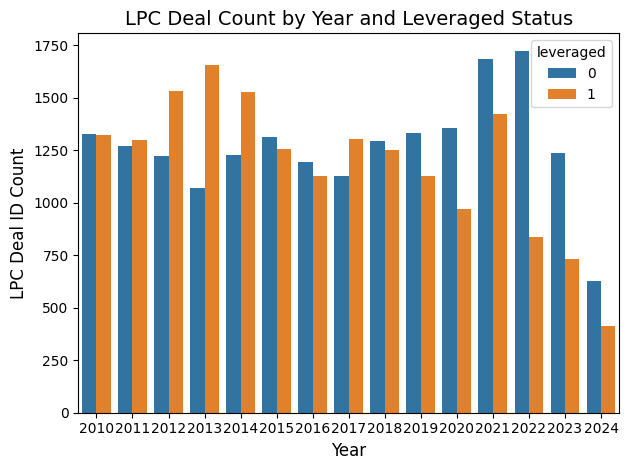

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'deal_count' contains the data
sns.barplot(x='year', y='lpc_deal_id', hue='leveraged', data=deal_count, ci=None)

# Add labels and a title
plt.xlabel('Year', fontsize=12)
plt.ylabel('LPC Deal ID Count', fontsize=12)
plt.title('LPC Deal Count by Year and Leveraged Status', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

In [3]:
# obtain Dealscan legacy lenders data (to use 2018 JF bank name link)
query = f"""
    SELECT *
    FROM tr_dealscan.lendershares
"""
lendershares = db.raw_sql(query)

# output csv. format
lendershares.to_csv("../Data/Raw/lendershares.csv", index=False)

In [4]:
# Disconnect from WRDS
db.close()